In [75]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np


onwards_2016 = False
add_to_fig = "from_2016_onwards" if onwards_2016 else ""

First, we load the data and exclude Australia ( to far away), Marocco (only participated once) 
and Yugslawia and Serbia-Montenegro ( both historic states)

We check that all our data have values on the most simple points

In [76]:
# Load the data
votes = pd.read_csv("../data/fulldata.csv")

votes["round"] = votes["round"].astype("category")

votes = votes[votes["distance"] > 0]
votes = votes[votes["round"] == "final"]


votes = votes[votes["from_country"] != votes["to_country"]] #exclude self-votes
votes = votes[~votes["to_country"].isin(["au", "yu", "cs", "ma"])] # exclude Australia, Yugoslavia, Serbia and Montenegro, Morocco
votes = votes[~votes["from_country"].isin(["au", "yu", "cs", "ma"])] # exclude Australia, Yugoslavia, Serbia and Montenegro, Morocco
if onwards_2016:
    votes = votes[votes["year"] >= 2016] #exclude years before 2016

length_before = len(votes)
print("Rows before dropping NA Collums:", length_before)
votes.columns
votes = votes.dropna(subset=["from_country", "to_country", "distance", "total_points"])
length_after = len(votes)

print("Dropped", length_before - length_after, "rows due to missing values")

print("Rows before dropping NA after forcing numeric:", length_before)
length_before = length_after
print(votes.columns)

Rows before dropping NA Collums: 6749
Dropped 0 rows due to missing values
Rows before dropping NA after forcing numeric: 6749
Index(['Unnamed: 0', 'year', 'round', 'from_country', 'to_country',
       'total_points', 'tele_points', 'jury_points', 'Year_from',
       'iso-alpha-3_from', 'chrstprotpct_from', 'chrstcatpct_from',
       'chrstorthpct_from', 'judgenpct_from', 'islmgenpct_from',
       'nonreligpct_from', 'StateAbb_from', 'city_from', 'lat_from',
       'lon_from', 'GDP per capita (current US$)_from',
       'Population, total_from', 'Year_to', 'iso-alpha-3_to',
       'chrstprotpct_to', 'chrstcatpct_to', 'chrstorthpct_to', 'judgenpct_to',
       'islmgenpct_to', 'nonreligpct_to', 'StateAbb_to', 'city_to', 'lat_to',
       'lon_to', 'GDP per capita (current US$)_to', 'Population, total_to',
       'distance', 'jaccard_artists', 'jaccard_genre', 'dice_genre',
       'dice_artists'],
      dtype='object')


/tmp/ipykernel_959/840765235.py:2: DtypeWarning: Columns (20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  votes = pd.read_csv("../data/fulldata.csv")


Now we check if all the GDP data is actually numeric and drop rows that are not. We can track, how many  values are now missing. 
San Mario is missing GDP  values for 2023

In [77]:
votes
subset=["GDP per capita (current US$)_from", "GDP per capita (current US$)_to"]

length_before = len(votes)
votes.replace("..",float("nan"),inplace=True)

#print(votes['GDP per capita (current US$)_to'])
votes["GDP per capita (current US$)_from"] = pd.to_numeric(votes["GDP per capita (current US$)_from"], errors='coerce')
votes["GDP per capita (current US$)_to"] = pd.to_numeric(votes["GDP per capita (current US$)_to"], errors='coerce')
rows_with_na = votes[votes[subset].isna().any(axis=1)]

print("Rows with missing values:")
print(rows_with_na)
votes = votes.dropna(subset=subset)
length_after = len(votes)
print("Dropped", length_before - length_after, "rows due to missing values in GDP per capita")
print("Rows after dropping NA:", length_after)




/tmp/ipykernel_959/69908046.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  votes.replace("..",float("nan"),inplace=True)


Rows with missing values:
       Unnamed: 0  year  round from_country to_country  total_points  \
47220       47220  2023  final           sm         se            12   
47221       47221  2023  final           sm         fi            12   
47222       47222  2023  final           sm         il            10   
47223       47223  2023  final           sm         it            19   
47224       47224  2023  final           sm         no             5   
47225       47225  2023  final           sm         ua             6   
47226       47226  2023  final           sm         be             7   
47227       47227  2023  final           sm         ee            10   
47229       47229  2023  final           sm         cz             0   
47230       47230  2023  final           sm         lt            10   
47231       47231  2023  final           sm         cy             5   
47232       47232  2023  final           sm         hr             0   
47233       47233  2023  final        

The religios data does not include Serbia, so we can right  anywway.
As you can see for 2016>= the relgion data is complete otherwise

In [78]:
#Compute difference so that we can use that as varible in the regression

votes["GDP_Difference"] = votes["GDP per capita (current US$)_from"] - votes["GDP per capita (current US$)_to"]

if onwards_2016:
    # we know that this data is incomplete , so we will only look at newer data, where we have more complete data
    religious_differences = ["Catholism_Difference", "Protestant_Difference", "Islam_Difference", "Judaism_Difference", "Orthodox_Difference"]
    votes = votes[~votes["from_country"].isin(["rs"])] #exclude Serbia
    votes = votes[~votes["to_country"].isin(["rs"])] #exclude Serbia

    
    votes["Catholism_Difference"] = votes["chrstcatpct_from"] - votes["chrstcatpct_to"]

    votes["Protestant_Difference"] = votes["chrstprotpct_from"] - votes["chrstprotpct_to"]

    votes["Islam_Difference"] = votes["islmgenpct_from"] - votes["islmgenpct_to"]

    votes["Judaism_Difference"] = votes["judgenpct_from"] - votes["judgenpct_to"]

    votes["Orthodox_Difference"] = votes["chrstorthpct_from"] - votes["chrstorthpct_to"]

    votes["Non_religious_Difference"] = votes["nonreligpct_from"] - votes["nonreligpct_to"]

    length_before = len(votes)
    print("Rows before dropping NA Collums:", length_before)

    rows_with_na = votes[votes[religious_differences].isna().any(axis=1)]

    print("Rows with missing values:")
    print(rows_with_na)
    votes = votes.dropna(subset=["Catholism_Difference", "Protestant_Difference", "Islam_Difference", "Judaism_Difference"])
    length_after = len(votes)
    print("Dropped", length_before - length_after, "rows due to missing values in religion data")

Rows before dropping NA Collums: 6326
Rows with missing values:
Empty DataFrame
Columns: [Unnamed: 0, year, round, from_country, to_country, total_points, tele_points, jury_points, Year_from, iso-alpha-3_from, chrstprotpct_from, chrstcatpct_from, chrstorthpct_from, judgenpct_from, islmgenpct_from, nonreligpct_from, StateAbb_from, city_from, lat_from, lon_from, GDP per capita (current US$)_from, Population, total_from, Year_to, iso-alpha-3_to, chrstprotpct_to, chrstcatpct_to, chrstorthpct_to, judgenpct_to, islmgenpct_to, nonreligpct_to, StateAbb_to, city_to, lat_to, lon_to, GDP per capita (current US$)_to, Population, total_to, distance, jaccard_artists, jaccard_genre, dice_genre, dice_artists, GDP_Difference, Catholism_Difference, Protestant_Difference, Islam_Difference, Judaism_Difference, Orthodox_Difference, Non_religious_Difference]
Index: []

[0 rows x 48 columns]
Dropped 0 rows due to missing values in religion data


In [79]:
votes.head

<bound method NDFrame.head of        Unnamed: 0  year  round from_country to_country  total_points  \
36099       36099  2016  final           al         ua             6   
36101       36101  2016  final           al         ru            14   
36102       36102  2016  final           al         bg            12   
36103       36103  2016  final           al         se             3   
36104       36104  2016  final           al         fr            10   
...           ...   ...    ...          ...        ...           ...   
47415       47415  2023  final           gb         ch             0   
47416       47416  2023  final           gb         si             1   
47417       47417  2023  final           gb         al             0   
47418       47418  2023  final           gb         pt             0   
47420       47420  2023  final           gb         de             0   

       tele_points  jury_points  Year_from iso-alpha-3_from  ...  \
36099          6.0          0.0      

We normalize the continous variable to better compare effect size

In [80]:
votes["distance"] = votes["distance"].astype("int")

#Normalize the data
votes["distance"] = (votes["distance"] - votes["distance"].mean()) / votes[
    "distance"
].std()
votes["GDP_Difference"] = (votes["GDP_Difference"] - votes["GDP_Difference"].mean()) / votes[
    "GDP_Difference"
].std()

if onwards_2016:
    votes["Catholism_Difference"] = (votes["Catholism_Difference"] - votes["Catholism_Difference"].mean()) / votes[
        "Catholism_Difference"
    ].std()
    votes["Protestant_Difference"] = (votes["Protestant_Difference"] - votes["Protestant_Difference"].mean()) / votes[
        "Protestant_Difference"
    ].std()

    votes["Orthodox_Difference"] = (votes["Orthodox_Difference"] - votes["Orthodox_Difference"].mean()) / votes["Orthodox_Difference"].std()
    votes["Islam_Difference"] = (votes["Islam_Difference"] - votes["Islam_Difference"].mean()) / votes[
        "Islam_Difference"
    ].std()
    votes["Judaism_Difference"] = (votes["Judaism_Difference"] - votes["Judaism_Difference"].mean()) / votes[
        "Judaism_Difference"
    ].std()

    votes["Non_religious_Difference"] = (votes["Non_religious_Difference"] - votes["Non_religious_Difference"].mean()) /  votes["Non_religious_Difference"].std()




In [81]:
def display_q_q_plot(residual_name):
    import scipy.stats as stats
    stats.probplot(votes[residual_name], dist="norm", plot=plt)
    plt.title("Q-Q Plot of " + residual_name)
    plt.savefig("../plots/linear_effects/q_q_plot_" + residual_name + add_to_fig + ".png")
    return

In [82]:
re_formula = "1"


if onwards_2016:
    print("Running model from 2016 onwards")
    """mixed_model = smf.mixedlm(
        formula="total_points ~ distance + GDP_Difference + Catholism_Difference + Protestant_Difference + Islam_Difference + Judaism_Difference +  Non_religious_Difference+ Orthodox_Difference+ dice_genre + dice_artists",
        data=votes,
        re_formula="1",
        groups=votes["from_country"],
    ).fit(reml=False)"""

    tele_model = smf.mixedlm("tele_points ~ distance + GDP_Difference +  dice_genre + dice_artists", re_formula=re_formula, data=votes, groups=votes["from_country"]).fit(reml=False)

    jury_model = smf.mixedlm("jury_points ~ distance + GDP_Difference + dice_genre + dice_artists",  re_formula=re_formula,data=votes, groups=votes["from_country"]).fit(reml=False)


    
else:
    
    print("Running model without religion data")
    mixed_model = smf.mixedlm(
        formula="total_points ~ distance + GDP_Difference + dice_genre + dice_artists",
        re_formula=re_formula, 
        data=votes,
        groups=votes["from_country"],
    ).fit(reml=False)


    
    
    votes["residuals"] = mixed_model.resid
    votes["fitted_values"] = mixed_model.fittedvalues
    print(mixed_model.summary())
    print("Quality of fit:",mixed_model.aic)
    print("p_values:", mixed_model.pvalues)

    

Running model from 2016 onwards


/home/goon/miniconda3/envs/eurovision/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/goon/miniconda3/envs/eurovision/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/goon/miniconda3/envs/eurovision/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/goon/miniconda3/envs/eurovision/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/home/goon/miniconda3/envs/eurovision/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be

We also create a model w/o the distance so we can compare the quality of the fit and have some estimation if we overfit

In [83]:
if  not onwards_2016:
    w_o_distance = smf.mixedlm("total_points ~ GDP_Difference + dice_genre + dice_artists", data=votes,  re_formula=re_formula,groups=votes["from_country"]).fit(reml=False)
    print(w_o_distance.summary())
    print("Quality of fit:",w_o_distance.aic)
    print("p_values:", w_o_distance.pvalues)

    difference_as_prob = np.exp((mixed_model.aic - w_o_distance.aic)/2)
    print("Difference as probability" , difference_as_prob)

In [84]:
if not onwards_2016:
    display_q_q_plot("residuals")

In [85]:
if onwards_2016:
    print("tele model:")
    print(tele_model.summary())
    

    votes["tele_predicted"] = tele_model.fittedvalues
    #votes["jury_predicted"] = jury_model.fittedvalues
    votes["tele_residuals"] = tele_model.resid
    #votes["jury_residuals"] = jury_model.resid

tele model:
          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: tele_points
No. Observations:  6326    Method:             ML         
No. Groups:        42      Scale:              12.0725    
Min. group size:   24      Log-Likelihood:     -16871.8190
Max. group size:   168     Converged:          Yes        
Mean group size:   150.6                                  
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       2.109    0.109  19.352 0.000  1.895  2.322
distance       -0.627    0.055 -11.430 0.000 -0.734 -0.519
GDP_Difference  0.133    0.054   2.480 0.013  0.028  0.239
dice_genre     -1.356    0.350  -3.871 0.000 -2.042 -0.669
dice_artists    1.599    0.341   4.695 0.000  0.931  2.267
Group Var       0.099    0.013                            



GOodness of fit:
-16871.819012616663


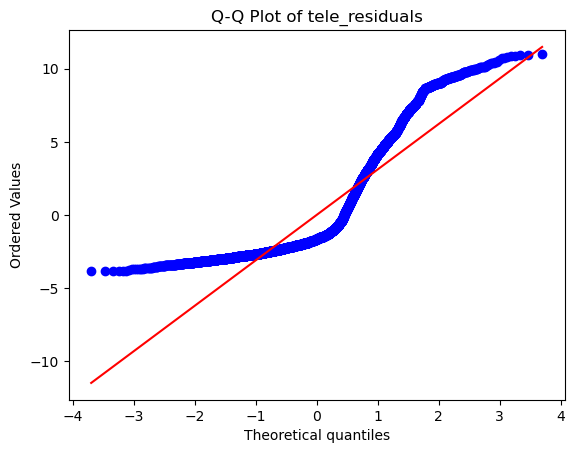

In [86]:
if onwards_2016:
    display_q_q_plot("tele_residuals")
    print("GOodness of fit:")
    print(tele_model.llf)

In [87]:
if onwards_2016:
    
    print("jury model:")
    print(jury_model.summary())


    #adding residuals to the data
    

jury model:
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: jury_points
No. Observations: 6326    Method:             ML         
No. Groups:       42      Scale:              12.2750    
Min. group size:  24      Log-Likelihood:     inf        
Max. group size:  168     Converged:          Yes        
Mean group size:  150.6                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.000                                    
distance       -0.234    0.052 -4.478 0.000 -0.337 -0.132
GDP_Difference -0.222    0.065 -3.407 0.001 -0.350 -0.094
dice_genre     -0.132    0.381 -0.346 0.729 -0.878  0.615
dice_artists    1.092    0.354  3.085 0.002  0.398  1.785
Group Var       0.000                                    



/home/goon/miniconda3/envs/eurovision/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2704: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [88]:
#display_q_q_plot("jury_residuals")

In [89]:

if not onwards_2016:

    # Plot the residuals
    plt.scatter(votes["fitted_values"], votes["residuals"])
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs. Fitted values")
    plt.axhline(y=0, color="black", linestyle="--")
    plt.savefig("../plots/linear_effects/residuals_vs_fitted_values" + add_to_fig + ".png")
    plt.show()

KeyError: 'fitted_values'

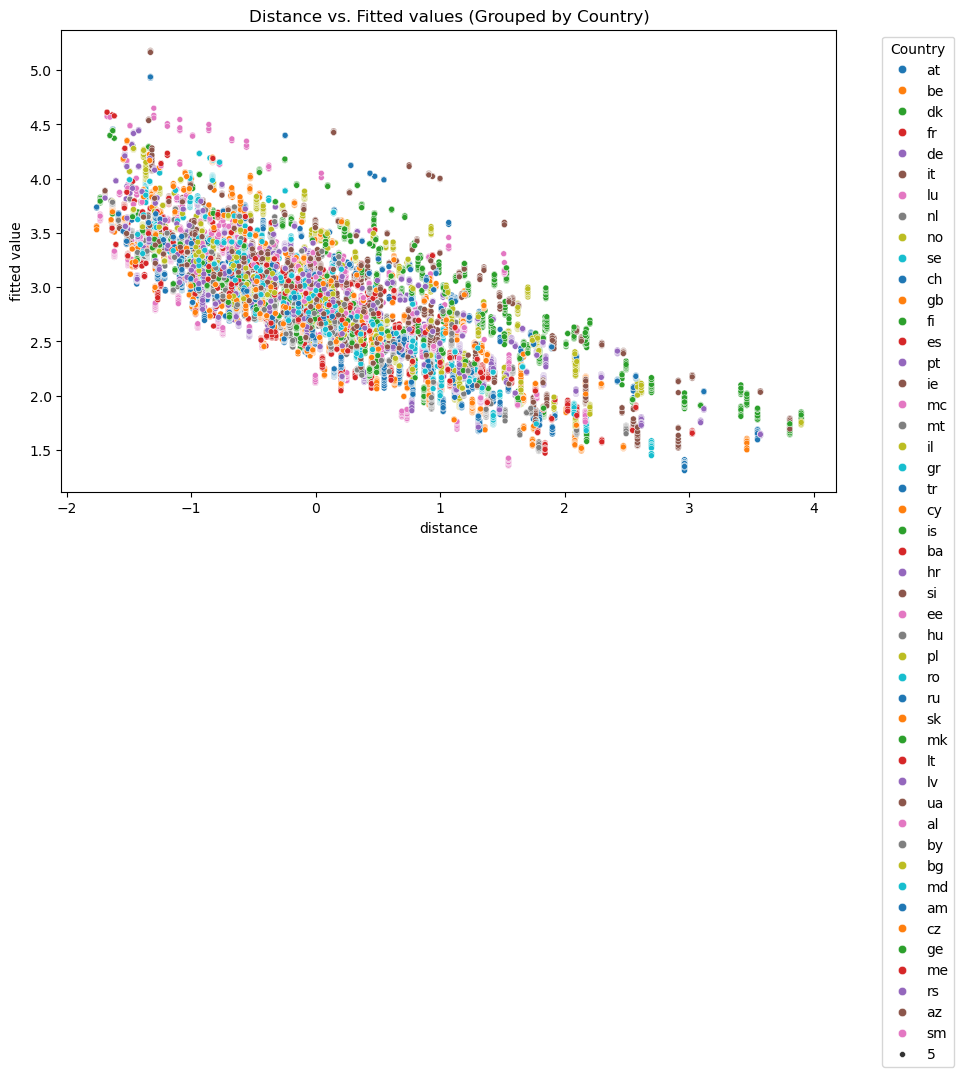

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'votes' has a column 'country' for grouping
sizes = [5 for _ in range(len(votes))]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=votes, 
    x="distance", 
    y="fitted_values", 
    hue="from_country",  # Group by country
    size=sizes, 
    palette="tab10"  # Use a predefined palette
)
plt.xlabel("distance")
plt.ylabel("fitted value")
plt.title("Distance vs. Fitted values (Grouped by Country)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



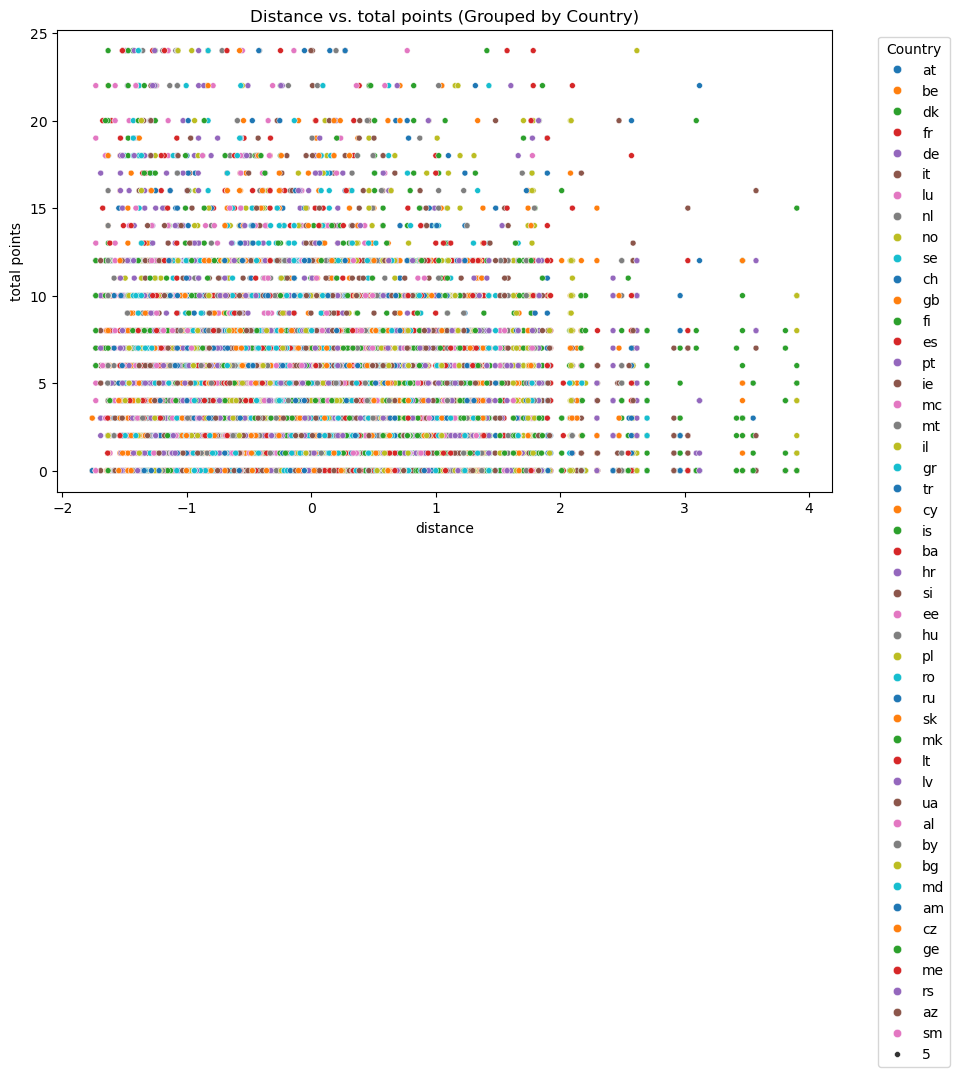

In [ ]:
# Assuming 'votes' has a column 'country' for grouping
sizes = [5 for _ in range(len(votes))]
#votes = votes[votes["from_country"] == "de"]
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=votes, 
    x="distance", 
    y="total_points", 
    hue="from_country",  # Group by country
    size=sizes, 
    palette="tab10"  # Use a predefined palette
)
plt.xlabel("distance")
plt.ylabel("total points")
plt.title("Distance vs. total points (Grouped by Country)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

As we can see, the residuals clearly don't follow a normal distribution. Therefore our analysis should be regarded with caution

/tmp/ipykernel_959/2564329060.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


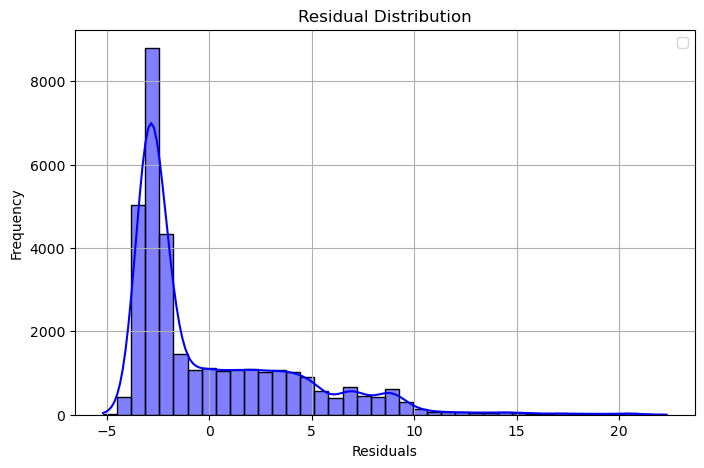

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(votes["residuals"], bins=40, color="blue", alpha=0.5, kde=True)

plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.legend()
plt.grid(True)

plt.savefig(f"../plots/linear_effects/residuals_{add_to_fig}.png")
plt.show()

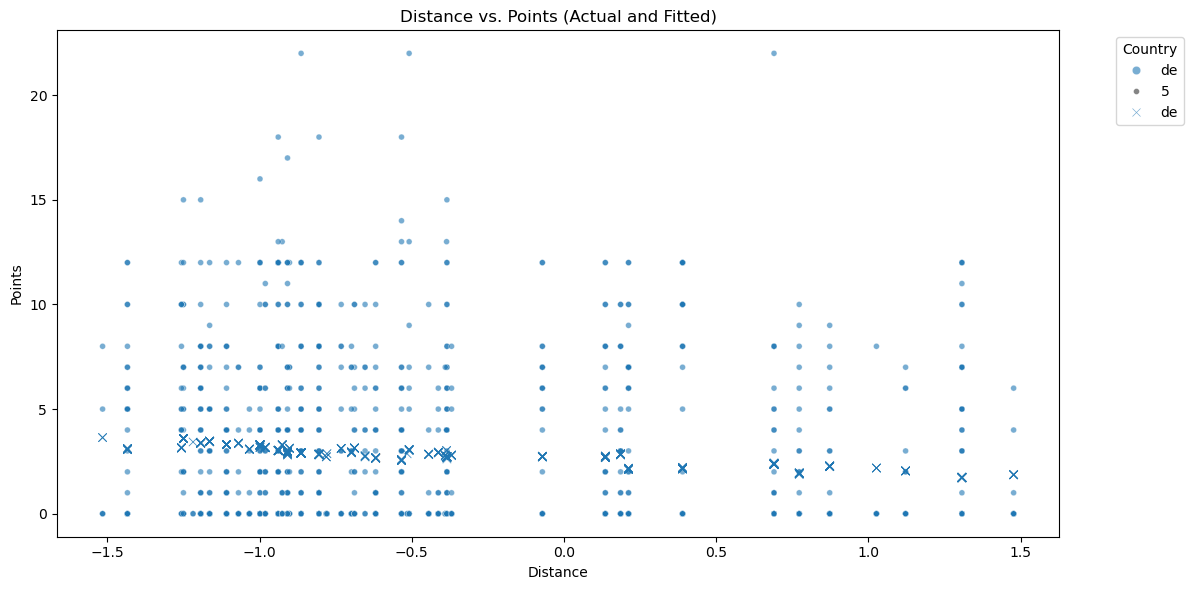

In [ ]:
# Assuming 'votes' has columns 'country', 'distance', 'total_points', and 'fitted'
plt.figure(figsize=(12, 6))  # Made figure wider to accommodate legend
exclusion_votes = votes[votes["from_country"].isin(["de",
                                                     "es",
                                                       "cy"
                                                       ])]# Plot actual points
sizes = [5 for _ in range(len(exclusion_votes))]
sns.scatterplot(
    data=exclusion_votes,
    x="distance",
    y="total_points",
    hue="from_country",
    size=sizes,
    palette="tab10",
    #label="Actual Points",
    alpha=0.6
)

# Plot fitted values with 'x' markers
sns.scatterplot(
    data=exclusion_votes,
    x="distance",
    y="fitted_values",
    hue="from_country",
    marker='x',
    sizes=sizes,  # Size for x markers
     palette="tab10",
    #label="Fitted Values"
    alpha=0.6
)

plt.xlabel("Distance")
plt.ylabel("Points")
plt.title("Distance vs. Points (Actual and Fitted)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.savefig(f"../plots/linear_effects/actual_vs_fitted_{add_to_fig}.png")
plt.show()